In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import os


In [8]:
MJTCP = 32292 #Michael Jordan total career points
def assign_rnd_integer(dataset, number_of_times = 5, seed = MJTCP):
    new_dataset = pd.DataFrame()
    np.random.seed(seed)
    for c in dataset.columns:
        for i in range(number_of_times):
            col_name = c+"_"+str(i)
            unique_vals = dataset[c].unique()
            labels = np.array(list(range(len(unique_vals))))
            np.random.shuffle(labels)
            mapping = pd.DataFrame({c: unique_vals, col_name: labels})
            new_dataset[col_name] = (dataset[[c]]
                                     .merge(mapping, on = c, how = 'left')[col_name]
                                    ).values
    return new_dataset

In [9]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

def extract_col_interaction(dataset, col1, col2, tfidf = True):
    data = dataset.groupby([col1])[col2].agg(lambda x: " ".join(list([str(y) for y in x])))
    if tfidf:
        vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(" "))
    else:
        vectorizer = CountVectorizer(tokenizer=lambda x: x.split(" "))
    
    data_X = vectorizer.fit_transform(data)
    dim_red = TruncatedSVD(n_components=1, random_state = 5511)
    data_X = dim_red.fit_transform(data_X)
    
    result = pd.DataFrame()
    result[col1] = data.index.values
    result[col1+"_{}_svd".format(col2)] = data_X.ravel()
    return result

In [10]:
import itertools
def get_col_interactions_svd(dataset, tfidf = True):
    new_dataset = pd.DataFrame()
    for col1,col2 in itertools.permutations(dataset.columns, 2):
        data = extract_col_interaction(dataset, col1,col2, tfidf)
        col_name = [x for x in data.columns if "svd" in x][0]
        new_dataset[col_name] = (dataset[[col1]]
                                 .merge(data, on = col1, how = 'left')
                                )[col_name]
    return new_dataset

def get_freq_encoding(dataset):
    new_dataset = pd.DataFrame()
    for c in dataset.columns:
        data = dataset.groupby([c]).size().reset_index()
        new_dataset[c+"_freq"] = dataset[[c]].merge(data, on = c, how = "left")[0]
    return new_dataset

def transform_dataset(train, test, func, func_params = {}):
    dataset = pd.concat([train, test], ignore_index = True)
    dataset = func(dataset, **func_params)
    if isinstance(dataset, pd.DataFrame):
        new_train = dataset.iloc[:train.shape[0],:].reset_index(drop = True)
        new_test =  dataset.iloc[train.shape[0]:,:].reset_index(drop = True)
    else:
        new_train = dataset[:train.shape[0]]
        new_test =  dataset[train.shape[0]:]
    return new_train, new_test

In [11]:
import lightgbm as lgbm

def get_model(params):
    return lgbm.LGBMClassifier(
        n_estimators=250,
        metric='auc',
        objective='binary', 
        n_jobs=3,
        random_state = 42,
        **params
    )

In [12]:
class TargetEncoding():
    def __init__(self, columns_names ):
        self.columns_names = columns_names
        self.learned_values = {}
        self.dataset_mean = np.nan
    def fit(self, X, y, **fit_params):
        X_ = X.copy()
        self.learned_values = {}
        X_["__target__"] = y
        for c in [x for x in X_.columns if x in self.columns_names]:
            self.learned_values[c] = (X_[[c,"__target__"]]
                                      .groupby(c)["__target__"].mean()
                                      .reset_index())

        self.dataset_mean = np.mean(y)
        return self
    def transform(self, X, **fit_params):
        transformed_X = X[self.columns_names].copy()
        for c in transformed_X.columns:
            transformed_X[c] = (transformed_X[[c]]
                                .merge(self.learned_values[c], on = c, how = 'left')
                               )["__target__"]
        transformed_X = transformed_X.fillna(self.dataset_mean)
        return transformed_X
    def fit_transform(self, X, y, **fit_params):
        self.fit(X,y)
        return self.transform(X)
    

In [13]:
from sklearn.model_selection import StratifiedKFold
def get_CV_target_encoding(data, y, encoder, cv = 5):
    skfTE = StratifiedKFold(n_splits=cv, random_state = 545167, shuffle = True)
    result = []
    for train_indexTE, test_indexTE in skfTE.split(data, y):
        encoder.fit(data.iloc[train_indexTE,:].reset_index(drop = True), y[train_indexTE])
        tmp =  encoder.transform(data.iloc[test_indexTE,:].reset_index(drop = True))
        tmp["index"] = test_indexTE
        result.append(tmp)
    result = pd.concat(result, ignore_index = True)
    result = result.sort_values('index').reset_index(drop = True).drop('index', axis = 1)
    return result

In [16]:
# Loading data directly from CatBoost
from catboost.datasets import amazon
train, test = amazon()
# train.describe

In [8]:
target = "ACTION"
col4train = [x for x in train.columns if x not in [target, "ROLE_TITLE"]]
y = train[target].values

train[col4train] = train[col4train].values.astype(str)
test[col4train] = test[col4train].values.astype(str)

from itertools import combinations
new_col4train = col4train
for c1,c2 in combinations(col4train, 2):
    name = "{}_{}".format(c1,c2)
    new_col4train.append(name)
    train[name] = train[c1] + "_" + train[c2]
    test[name] = test[c1] + "_" + test[c2]

In [9]:
#dataset #1
cols_svd = ['MGR_ID_ROLE_CODE','MGR_ID_ROLE_DEPTNAME','MGR_ID_ROLE_FAMILY', 
            'RESOURCE_MGR_ID','RESOURCE_ROLE_CODE', 'RESOURCE_ROLE_FAMILY',
            'RESOURCE_ROLE_ROLLUP_1','RESOURCE_ROLE_ROLLUP_2','RESOURCE',
            'ROLE_DEPTNAME_ROLE_CODE','ROLE_DEPTNAME_ROLE_FAMILY',
            'ROLE_FAMILY_DESC_ROLE_FAMILY','ROLE_FAMILY_ROLE_CODE',
            'ROLE_FAMILY','ROLE_ROLLUP_1_ROLE_DEPTNAME',
            'ROLE_ROLLUP_1_ROLE_FAMILY_DESC', 'ROLE_ROLLUP_1_ROLE_FAMILY',
            'ROLE_ROLLUP_1','ROLE_ROLLUP_2']

cols_rnd = ['MGR_ID_ROLE_DEPTNAME','MGR_ID_ROLE_FAMILY','MGR_ID_ROLE_ROLLUP_1',
 'MGR_ID_ROLE_ROLLUP_2','MGR_ID','RESOURCE_MGR_ID','RESOURCE_ROLE_CODE',
 'RESOURCE_ROLE_FAMILY_DESC','RESOURCE_ROLE_FAMILY','RESOURCE_ROLE_ROLLUP_1',
 'RESOURCE_ROLE_ROLLUP_2','ROLE_DEPTNAME_ROLE_FAMILY_DESC','ROLE_FAMILY_DESC_ROLE_CODE',
 'ROLE_FAMILY_DESC_ROLE_FAMILY','ROLE_FAMILY','ROLE_ROLLUP_1_ROLE_CODE',
 'ROLE_ROLLUP_1_ROLE_DEPTNAME','ROLE_ROLLUP_1_ROLE_FAMILY_DESC','ROLE_ROLLUP_2_ROLE_FAMILY']

cols_freq = ['MGR_ID_ROLE_DEPTNAME','RESOURCE_MGR_ID','RESOURCE_ROLE_CODE',
 'RESOURCE_ROLE_DEPTNAME','RESOURCE_ROLE_FAMILY_DESC','RESOURCE_ROLE_FAMILY',
 'RESOURCE_ROLE_ROLLUP_1','ROLE_DEPTNAME_ROLE_FAMILY_DESC','ROLE_DEPTNAME_ROLE_FAMILY',
 'ROLE_DEPTNAME','ROLE_FAMILY_DESC_ROLE_CODE','ROLE_FAMILY_DESC_ROLE_FAMILY',
 'ROLE_ROLLUP_1_ROLE_CODE','ROLE_ROLLUP_2_ROLE_DEPTNAME']

data_svd = transform_dataset(train[cols_svd], test[cols_svd], get_col_interactions_svd)
data_rnd = transform_dataset(train[cols_rnd], test[cols_rnd], 
                             assign_rnd_integer, {"number_of_times":5})
data_freq = transform_dataset(train[cols_freq], test[cols_freq], get_freq_encoding)


In [10]:
data_train = pd.concat([x[0] for x in [data_svd, data_rnd, data_freq]], axis = 1)
data_test = pd.concat([x[1] for x in [data_svd, data_rnd, data_freq]], axis = 1)


In [11]:
print("Dataset shape, Train: {}, Test: {}".format(data_train.shape, data_test.shape))

Dataset shape, Train: (32769, 447), Test: (58921, 447)


In [12]:


del([data_svd, data_rnd, data_freq])
gc.collect()
data_train = data_train.values
data_test = data_test.values
gc.collect()



0

In [13]:
params = {'colsample_bytree': 0.312002398119274,
 'lambda_l1': 1.919962415701389,
 'learning_rate': 0.03363113877976891,
 'max_bin': 484,
 'max_depth': 10,
 'min_child_weight': 0.035307873174480586,
 'num_leaves': 220}

model = get_model(params)
model.fit(data_train, y)
predictions_1 = model.predict_proba(data_test)[:,1]

In [14]:
del([data_train, data_test, model])
gc.collect()

49

In [15]:
#dataset #2
cols_svd = ['MGR_ID','RESOURCE_MGR_ID','RESOURCE_ROLE_CODE',
 'RESOURCE_ROLE_DEPTNAME','RESOURCE_ROLE_FAMILY_DESC','RESOURCE_ROLE_FAMILY',
 'RESOURCE_ROLE_ROLLUP_1','RESOURCE','ROLE_CODE',
 'ROLE_DEPTNAME_ROLE_CODE','ROLE_DEPTNAME_ROLE_FAMILY','ROLE_FAMILY_DESC_ROLE_CODE',
 'ROLE_FAMILY_DESC_ROLE_FAMILY','ROLE_FAMILY_DESC','ROLE_ROLLUP_1_ROLE_DEPTNAME',
 'ROLE_ROLLUP_1_ROLE_FAMILY','ROLE_ROLLUP_1_ROLE_ROLLUP_2','ROLE_ROLLUP_2_ROLE_FAMILY_DESC',
 'ROLE_ROLLUP_2_ROLE_FAMILY','ROLE_ROLLUP_2']

cols_rnd = ['MGR_ID_ROLE_CODE','MGR_ID_ROLE_DEPTNAME','MGR_ID_ROLE_FAMILY_DESC',
 'MGR_ID_ROLE_ROLLUP_1','MGR_ID','RESOURCE_ROLE_DEPTNAME',
 'RESOURCE_ROLE_FAMILY','RESOURCE_ROLE_ROLLUP_1','ROLE_CODE',
 'ROLE_DEPTNAME_ROLE_FAMILY_DESC','ROLE_FAMILY_DESC_ROLE_CODE',
 'ROLE_FAMILY_DESC_ROLE_FAMILY','ROLE_FAMILY_ROLE_CODE',
 'ROLE_ROLLUP_1_ROLE_CODE','ROLE_ROLLUP_1_ROLE_FAMILY_DESC',
 'ROLE_ROLLUP_1_ROLE_ROLLUP_2']

cols_freq = ['MGR_ID_ROLE_CODE','MGR_ID_ROLE_DEPTNAME','MGR_ID_ROLE_ROLLUP_1',
 'MGR_ID_ROLE_ROLLUP_2','MGR_ID','RESOURCE_MGR_ID',
 'RESOURCE_ROLE_DEPTNAME','RESOURCE_ROLE_FAMILY_DESC','RESOURCE_ROLE_ROLLUP_2',
 'RESOURCE','ROLE_DEPTNAME_ROLE_FAMILY_DESC','ROLE_DEPTNAME',
 'ROLE_FAMILY_DESC','ROLE_FAMILY','ROLE_ROLLUP_1_ROLE_FAMILY_DESC',
 'ROLE_ROLLUP_1_ROLE_FAMILY','ROLE_ROLLUP_1_ROLE_ROLLUP_2',
 'ROLE_ROLLUP_1','ROLE_ROLLUP_2_ROLE_CODE','ROLE_ROLLUP_2']

cols_te = ['MGR_ID','RESOURCE_MGR_ID','RESOURCE_ROLE_CODE',
 'RESOURCE_ROLE_DEPTNAME','RESOURCE_ROLE_ROLLUP_2','RESOURCE',
 'ROLE_CODE','ROLE_DEPTNAME_ROLE_FAMILY_DESC','ROLE_DEPTNAME_ROLE_FAMILY',
 'ROLE_FAMILY_DESC_ROLE_CODE','ROLE_FAMILY_DESC','ROLE_FAMILY_ROLE_CODE',
 'ROLE_ROLLUP_1_ROLE_FAMILY','ROLE_ROLLUP_2_ROLE_FAMILY','ROLE_ROLLUP_2']

data_svd = transform_dataset(train[cols_svd], test[cols_svd], get_col_interactions_svd)
data_rnd = transform_dataset(train[cols_rnd], test[cols_rnd], 
                             assign_rnd_integer, {"number_of_times":5})
data_freq = transform_dataset(train[cols_freq], test[cols_freq], get_freq_encoding)

In [16]:
te = TargetEncoding(columns_names = cols_te)
data_te_tr = get_CV_target_encoding(train[cols_te], y, te, 5)
te.fit(train[cols_te], y)
data_te_te = te.transform(test[cols_te])

In [17]:
data_train = pd.concat([x[0] for x in [data_svd, data_rnd, data_freq]], axis = 1)
data_test = pd.concat([x[1] for x in [data_svd, data_rnd, data_freq]], axis = 1)
data_train = pd.concat([data_train, data_te_tr], axis = 1)
data_test = pd.concat([data_test, data_te_te], axis = 1)
print("Dataset shape, Train: {}, Test: {}".format(data_train.shape, data_test.shape))
del([data_svd, data_rnd, data_freq, data_te_tr, data_te_te])
gc.collect()
data_train = data_train.values
data_test = data_test.values
gc.collect()

Dataset shape, Train: (32769, 491), Test: (58921, 491)


0

In [18]:
params = {'colsample_bytree': 0.5280533549534434,
 'lambda_l1': 0.1267270702844549,
 'learning_rate': 0.012220447574715732,
 'max_bin': 131,
 'max_depth': 18,
 'min_child_weight': 1.1518716916679328,
 'num_leaves': 184}

model = get_model(params)
model.fit(data_train, y)
predictions_2 = model.predict_proba(data_test)[:,1]

del([data_train, data_test, model])
gc.collect()

80

In [21]:
submission = pd.DataFrame()
submission["Id"] = test["id"]
submission["ACTION"] = (predictions_1 + predictions_2) / 2



ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
submission.to_csv("submission.csv", index = False)

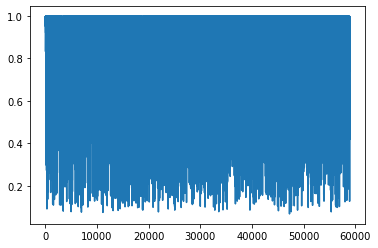

In [4]:
import pandas as pd

submission = pd.read_csv("submission.csv")
import matplotlib.pyplot as plt
plt.plot(submission["Id"], submission["ACTION"])
plt.show()